# Prep

In [1]:
# Import packages
import pandas as pd
import plotly.graph_objects as go
import networkx as nx
from ds_common_utils.aux.io.snowflake_tools import SnowflakeTools
from math import log
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain
import numpy as np

In [2]:
# Get connection
con = SnowflakeTools().get_snowflake_ctx(
     method = 'token',
    user = '250807',
    role = 'INSIGHT_ANALYST_MERCH_DE_GENERAL_PRD',
    warehouse = 'INSIGHT_ANALYST_WH'
)
with open('sql/item_association.sql', 'r') as query:
        df = pd.read_sql_query(query.read(), con)
with open('sql/excluded_class_list.sql', 'r') as query:
        target_item_class = pd.read_sql_query(query.read(), con)

snowflake_tools - 2025-06-20 10:41:59.076078+10:00 - Generating new token with 'INSIGHT_ANALYST_MERCH_DE_GENERAL_PRD' role and 'SESSION:ROLE-ANY' scope...
snowflake_tools - 2025-06-20 10:42:41.151551+10:00 - Saved token with '2025-06-20 14:42:41+10:00' expiry...


# Explore

In [9]:
with open('sql/overview.sql', 'r') as query:
        supplier_items = pd.read_sql_query(query.read(), con)
supplier_items        

,SALES_YEAR,ITEM_NUMBER,ITEM_DESCRIPTION,ITEM_CLASS_NAME,TRANSACTIONS,SALES_SUM,QUANTITY_SUM
0,2020,0823814,SKYLIGHT FIXED VELUX++780X1400MM FSM082004A,500 ROOF WINDOWS,23,750292,1365
1,2020,0028402,SKYLIGHT FLAT ROOF SOLAR OPEN++665X1275MM VCS...,500 ROOF WINDOWS,7,707584,420
2,2020,0823806,SKYLIGHT FIXED VELUX++780X1180MM FSM062004A,500 ROOF WINDOWS,20,531690,1085
3,2020,0823791,SKYLIGHT FIXED VELUX++780X980MM FSM042004A,500 ROOF WINDOWS,19,481119,1050
4,2020,0820122,SKYLIGHT FLAT ROOF VELUX++665X970MM FCM22340004AB,500 ROOF WINDOWS,16,420391,1085
...,...,...,...,...,...,...,...
684,2025,0508442,SKYLIGHT PLEATED BLIND++FIXED SKYLIGHT FS S01,500 SKYLIGHT ACCESSORIES,2,0,0
685,2025,0296315,VELUX FLASHING KIT++EDWSK060000,500 SKYLIGHT ACCESSORIES,2,0,0
686,2025,0028420,VELUX TRAY WTH BLIND++ZZZ 199 3046,500 SKYLIGHT ACCESSORIES,1,-11468,-56
687,2025,0138661,VELUX BLKOUT SOLAR++DSD C08 1025S,500 SKYLIGHT ACCESSORIES,1,-11948,-21


In [12]:
supplier_items.groupby(['SALES_YEAR', 'ITEM_CLASS_NAME']).agg(
        total_transactions=('TRANSACTIONS', 'sum'),
        total_sales=('SALES_SUM', 'sum'),
        total_quantity=('QUANTITY_SUM', 'sum'),
        item_count=('ITEM_NUMBER', 'nunique')
    ).reset_index()

,SALES_YEAR,ITEM_CLASS_NAME,total_transactions,total_sales,total_quantity,item_count
0,2020,500 ROOF WINDOWS,277,9350556,13482,48
1,2020,500 SKYLIGHT ACCESSORIES,194,1162715,5558,58
2,2021,500 ROOF WINDOWS,466,18066745,23513,50
3,2021,500 SKYLIGHT ACCESSORIES,368,3733848,13860,75
4,2022,500 ROOF WINDOWS,471,19596918,24598,56
5,2022,500 SKYLIGHT ACCESSORIES,291,3142363,10388,56
6,2023,500 ROOF WINDOWS,426,18149594,20657,52
7,2023,500 SKYLIGHT ACCESSORIES,247,2992703,8134,67
8,2024,500 ROOF WINDOWS,476,23295097,25326,54
9,2024,500 SKYLIGHT ACCESSORIES,326,4258881,12012,74


5year: 4K transactions, $116M sales, 174k quantity, 179 items.

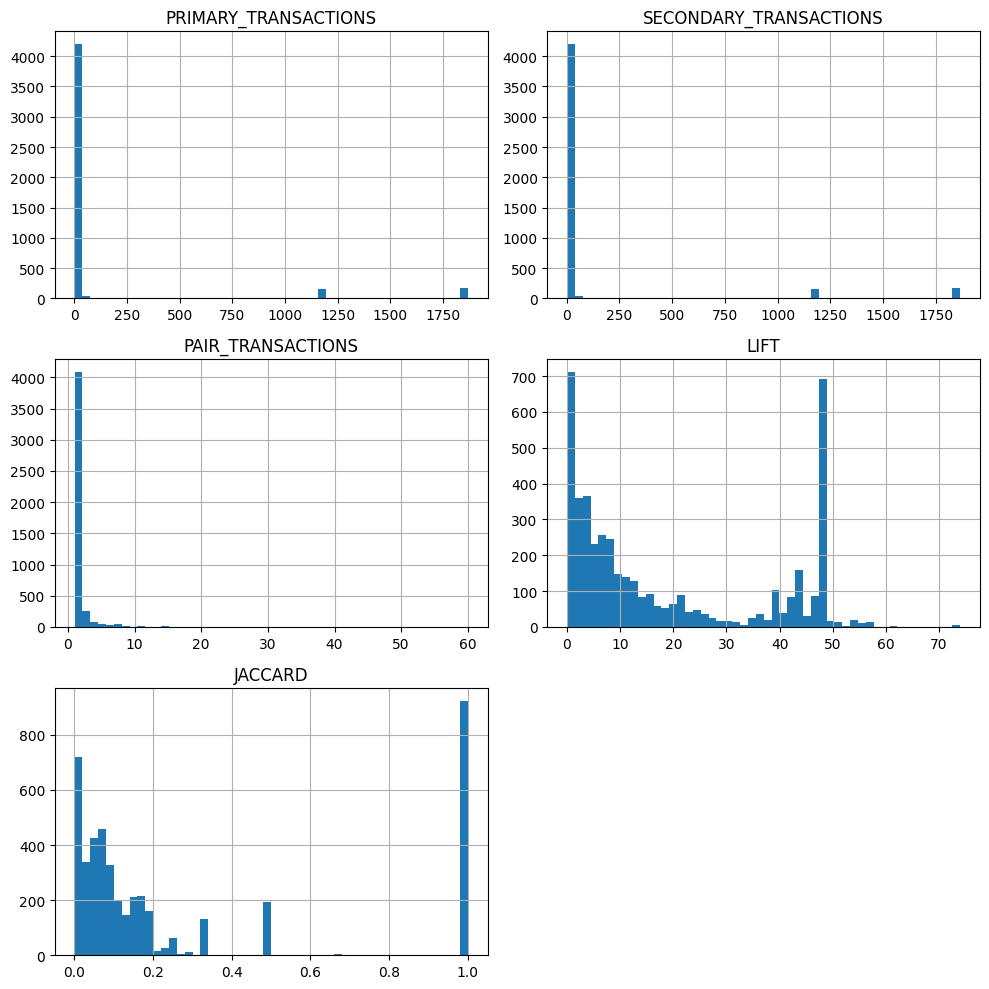

In [20]:
# Plot histograms of numerical columns
numeric_cols = df.select_dtypes(include='number').columns
df[numeric_cols].hist(bins=50, figsize=(10, 10), layout=(3, 2))
plt.tight_layout()
plt.show()

Heavily right-skewed; majority transaction counts are 1–5.

JACCARD: Bimodal - many near 0, many at 1, suggesting that some items only ever appear together (false high Jaccard).

LIFT: Spread out - many between 1–30, spike around 45+. Large lift often means secondary item is rare.

# Co-purchase classes with VELUX products

## Parameter tuning

In [229]:
TRX_THRESHOLD = 2 # Min N frequent pairs
QUANTILE = 0.7 # Nth percentile of metric similarity
TOP_N = 20 # top-N associated item classes per primary class
RESO = 1 # >1.0 → more, smaller communities
METRIC = 'JACCARD' # LIFT or JACCARD

## Working

In [230]:
filtered_df = df[
    df['PRIMARY_ID'].isin(target_item_class['ITEM_CLASS_NAME']) &
    ~df['SECONDARY_ID'].isin(target_item_class['ITEM_CLASS_NAME'])
]

filtered_df = filtered_df[filtered_df['PAIR_TRANSACTIONS'] >= TRX_THRESHOLD]
threshold = filtered_df[METRIC].quantile(QUANTILE)
filtered_df = filtered_df[filtered_df[METRIC] >= threshold]
top_edges = filtered_df.sort_values(METRIC, ascending=False).groupby('PRIMARY_ID').head(TOP_N)

In [231]:
filtered_df.sort_values(by='PAIR_TRANSACTIONS', ascending=False)

,PRIMARY_ID,SECONDARY_ID,PRIMARY_TRANSACTIONS,SECONDARY_TRANSACTIONS,TRX_START_MONTH,TRX_END_MONTH,PAIR_TRANSACTIONS,LIFT,JACCARD
2435,500 ROOF WINDOWS,500 BUILDING SUPPLIES OFFRANGE,1867,64,2020-07-01,2025-05-01,27,0.574853,0.014181
2533,500 ROOF WINDOWS,500 STRUCTURAL FRAMING H1 2 KD,1867,36,2020-07-01,2024-05-01,23,0.870559,0.012234
2443,500 ROOF WINDOWS,500 CONNECTORS,1867,27,2020-07-01,2025-05-01,22,1.110278,0.011752
2775,500 SKYLIGHT ACCESSORIES,500 BUILDING SUPPLIES OFFRANGE,1186,64,2020-08-01,2025-05-01,19,0.636804,0.015435
2486,500 ROOF WINDOWS,500 NON STRUCT TRTD PINE GAUGE,1867,24,2020-09-01,2025-03-01,18,1.021960,0.009610
2436,500 ROOF WINDOWS,500 BUILDING WRAP,1867,34,2021-03-01,2025-05-01,16,0.641230,0.008488
2558,500 ROOF WINDOWS,501 HM FURNISHINGS OFFRANGE,1867,21,2021-10-01,2025-05-01,16,1.038182,0.008547
2515,500 ROOF WINDOWS,500 PLYWOOD SHEETS,1867,19,2021-07-01,2025-05-01,15,1.075748,0.008017
2434,500 ROOF WINDOWS,500 BUILDING MATERIALS OFFRANG,1867,28,2021-03-01,2024-05-01,14,0.681307,0.007443
2462,500 ROOF WINDOWS,500 FIBRE CEMENT SHEETING ACC,1867,20,2020-12-01,2025-05-01,14,0.953830,0.007475


In [232]:
mode='lines',
line_shape='spline'
    
# Build node size map from your DataFrame
node_size_map = dict(zip(top_edges['PRIMARY_ID'], top_edges['PRIMARY_TRANSACTIONS']))

# Convert values to NumPy array
sizes = np.array(list(node_size_map.values()))

# Use np.ptp instead of .ptp()
norm_sizes = (sizes - sizes.min()) / np.ptp(sizes)  # scale to 0–1
scaled_sizes = 10 + norm_sizes * 30                 # scale to 10–40

# Final size map: Product ID → Scaled Size
scaled_size_map = dict(zip(node_size_map.keys(), scaled_sizes))

# Step 1: Build the full graph
G = nx.Graph()
for _, row in top_edges.iterrows():
    G.add_edge(row['PRIMARY_ID'], row['SECONDARY_ID'], weight=row[METRIC])

# Step 2: Louvain community detection
partition = community_louvain.best_partition(G, weight=METRIC, resolution=RESO)

# Step 3: Layout
pos = nx.spring_layout(G, weight='weight', seed=42
                      )

# Step 4: Edge trace (no filter on weight)
edge_x, edge_y = [], []
for u, v in G.edges():
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=1, color='gray'),
    hoverinfo='none',
    mode='lines'
)

# Step 5: Node trace with Louvain cluster coloring
color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']  # Extend if you expect >10 clusters

node_x, node_y, node_color, node_size, hover_text = [], [], [], [], []

for node in G.nodes():
    x, y = pos[node]
    cluster = partition[node]
    size = scaled_size_map.get(node, 10)  # default to small if missing

    node_x.append(x)
    node_y.append(y)
    node_color.append(color_list[cluster % len(color_list)])
    node_size.append(size)
    hover_text.append(f"Product ID: {node}<br>Cluster: {cluster}<br>Transactions: {int(size)}")

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    hoverinfo='text',
    text=[str(node) for node in G.nodes()],
    textposition='top center',
    marker=dict(
        color=node_color,
        size=node_size,  # <--- size now dynamic!
        line=dict(width=2, color='black')
    ),
    textfont=dict(
    size=16,          # increase for visibility
    color='black',
    family='Arial'
)
)
# Step 6: Plot
fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
        width=1200,          # increase width
    height=800, 
        title=dict(text='Louvain Product Clustering (All Edges)', x=0.5, font=dict(size=16)),
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20, l=20, r=20, t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )
)

## Results

In [233]:
fig.show()

In [239]:
# Merge community partition info with filtered edges
partition_df = pd.DataFrame.from_dict(partition, orient='index', columns=['segment']).reset_index()
partition_df.rename(columns={'index': 'PRIMARY_ID'}, inplace=True)

# Merge and deduplicate
labelled_df = filtered_df.merge(partition_df, on='PRIMARY_ID', how='left')
labelled_df = labelled_df[['PRIMARY_ID', 'SECONDARY_ID', 'PRIMARY_TRANSACTIONS', 'SECONDARY_TRANSACTIONS', 'PAIR_TRANSACTIONS', METRIC, 'segment']].drop_duplicates()
labelled_df = labelled_df.sort_values(by=['segment', METRIC]).reset_index(drop=True)
labelled_df

,PRIMARY_ID,SECONDARY_ID,PRIMARY_TRANSACTIONS,SECONDARY_TRANSACTIONS,PAIR_TRANSACTIONS,JACCARD,segment
0,500 SKYLIGHT ACCESSORIES,500 PLASTER CLADDING,1186,9,5,0.004202,0
1,500 SKYLIGHT ACCESSORIES,500 PAINT SILICONES,1186,7,5,0.004209,0
2,500 SKYLIGHT ACCESSORIES,OTHER DEPARMENT OFFRANGE C,1186,6,5,0.004212,0
3,500 SKYLIGHT ACCESSORIES,500 BUILDING WRAP,1186,34,6,0.004942,0
4,500 SKYLIGHT ACCESSORIES,500 FIBRE CEMENT SHEETING ACC,1186,20,6,0.005000,0
5,500 SKYLIGHT ACCESSORIES,500 PLYWOOD SHEETS,1186,19,6,0.005004,0
6,500 SKYLIGHT ACCESSORIES,500 COLLATED NAILS,1186,17,6,0.005013,0
7,500 SKYLIGHT ACCESSORIES,500 STRUCT FRAMG H1 2 KD LINKD,1186,12,6,0.005034,0
8,500 SKYLIGHT ACCESSORIES,500 TIMBER WEATHERBOARDS,1186,10,6,0.005042,0
9,500 SKYLIGHT ACCESSORIES,500 EXT CLADDING PLAIN,1186,9,6,0.005046,0


**Segment 0: Accessory-only purchases (flashing kits, motors, covers) likely linked to retrofit or finishing jobs. Smaller volumes, lower complexity.**

Lightweight fixings: COLLATED NAILS, CONNECTORS

Lining/substructure: PLYWOOD SHEETS, FIBRE CEMENT SHEETING ACC, PLASTER CLADDING

Timber & framing: STRUCT FRAMG H1, NON STRUCT TRTD PINE GAUGE

Packaging: BUILDING SUPPLIES OFFRANGE, HM FURNISHINGS OFFRANGE


**Segment 1: Full product install — likely new roof penetrations. Reflects higher material scope, extra framing, thermal barrier work.**

Same fixings and panels: COLLATED NAILS, PLYWOOD, CEMENT SHEETING

Additional framing complexity: STRUCT FRAMG H3, BATTEN, FASCIA, EAVE LINING

More insulation: GLASSWOOL, INSULATION BATTS

Other structural needs: BUILDING BRACKETS, BUILDING WRAP, WEATHERBOARDS

**Summary:** When commercial customers purchase VELUX skylights or accessories, they are not buying them in isolation. Instead, they are consistently purchasing a set of complementary building materials, indicating these products are part of a broader project kit:
- Wall preparation & cladding

- Roofline timber and fixings

- Ceiling/attic interior finishing

# Co-purchase classes (excluded VELUX products)

## Parameter tuning

In [656]:
TRX_THRESHOLD = 4 # Min N frequent pairs
QUANTILE = 0.8 # Nth percentile of metric similarity
TOP_N = 10 # top-N associated item classes per primary class
RESO = 1 # >1.0 → more, smaller communities
METRIC = 'JACCARD' # LIFT or JACCARD

## Working

In [657]:
filtered_df = df[
    ~(
        df['PRIMARY_ID'].isin(target_item_class['ITEM_CLASS_NAME']) |
        df['SECONDARY_ID'].isin(target_item_class['ITEM_CLASS_NAME'])
    )
]

filtered_df = filtered_df[filtered_df['PAIR_TRANSACTIONS'] >= TRX_THRESHOLD]
threshold = filtered_df[METRIC].quantile(QUANTILE)
filtered_df = filtered_df[filtered_df[METRIC] >= threshold]
top_edges = filtered_df.sort_values(METRIC, ascending=False).groupby('PRIMARY_ID').head(TOP_N)

In [658]:
filtered_df.sort_values(by='PAIR_TRANSACTIONS', ascending=False)

,PRIMARY_ID,SECONDARY_ID,PRIMARY_TRANSACTIONS,SECONDARY_TRANSACTIONS,TRX_START_MONTH,TRX_END_MONTH,PAIR_TRANSACTIONS,LIFT,JACCARD
342,500 BUILDING WRAP,500 FIBRE CEMENT SHEETING ACC,34,20,2020-08-01,2025-05-01,11,11.566176,0.255814
1042,500 FIBRE CEMENT SHEETING ACC,500 BUILDING WRAP,21,34,2020-08-01,2025-05-01,11,11.292717,0.250000
332,500 BUILDING WRAP,500 COLLATED NAILS,34,17,2021-06-01,2025-05-01,9,11.133218,0.214286
228,500 BUILDING BRACKETS,500 CONNECTORS,11,27,2021-06-01,2025-05-01,7,10.158249,0.225806
994,500 FIBRE CEMENT EAVE LINING,500 FIBRE CEMENT SHEETING ACC,12,20,2021-03-01,2025-02-01,7,12.395833,0.280000
1099,500 FIBRE CEMENT SHEETING ACC,501 BATTEN,21,14,2021-03-01,2025-03-01,7,17.452381,0.250000
1053,500 FIBRE CEMENT SHEETING ACC,500 FIBRE CEMENT EAVE LINING,21,11,2021-03-01,2025-02-01,7,22.212121,0.280000
3426,501 BATTEN,500 FIBRE CEMENT SHEETING ACC,15,20,2021-03-01,2025-03-01,7,12.576667,0.250000
639,500 CONNECTORS,500 BUILDING BRACKETS,27,11,2021-06-01,2025-05-01,7,25.077441,0.225806
1097,500 FIBRE CEMENT SHEETING ACC,500 WEATHERBOARDS,21,13,2022-06-01,2025-03-01,6,16.109890,0.214286


In [659]:
mode='lines',
line_shape='spline'
    
# Build node size map from your DataFrame
node_size_map = dict(zip(top_edges['PRIMARY_ID'], top_edges['PRIMARY_TRANSACTIONS']))

# Convert values to NumPy array
sizes = np.array(list(node_size_map.values()))

# Use np.ptp instead of .ptp()
norm_sizes = (sizes - sizes.min()) / np.ptp(sizes)  # scale to 0–1
scaled_sizes = 10 + norm_sizes * 30                 # scale to 10–40

# Final size map: Product ID → Scaled Size
scaled_size_map = dict(zip(node_size_map.keys(), scaled_sizes))

# Step 1: Build the full graph
G = nx.Graph()
for _, row in top_edges.iterrows():
    G.add_edge(row['PRIMARY_ID'], row['SECONDARY_ID'], weight=row[METRIC])

# Step 2: Louvain community detection
partition = community_louvain.best_partition(G, weight=METRIC, resolution=RESO)

# Step 3: Layout
pos = nx.spring_layout(G, weight='weight', seed=42
                      )

# Step 4: Edge trace (no filter on weight)
edge_x, edge_y = [], []
for u, v in G.edges():
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=1, color='gray'),
    hoverinfo='none',
    mode='lines'
)

# Step 5: Node trace with Louvain cluster coloring
color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']  # Extend if you expect >10 clusters

node_x, node_y, node_color, node_size, hover_text = [], [], [], [], []

for node in G.nodes():
    x, y = pos[node]
    cluster = partition[node]
    size = scaled_size_map.get(node, 10)  # default to small if missing

    node_x.append(x)
    node_y.append(y)
    node_color.append(color_list[cluster % len(color_list)])
    node_size.append(size)
    hover_text.append(f"Product ID: {node}<br>Cluster: {cluster}<br>Transactions: {int(size)}")

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    hoverinfo='text',
    text=[str(node) for node in G.nodes()],
    textposition='top center',
    marker=dict(
        color=node_color,
        size=node_size,  # <--- size now dynamic!
        line=dict(width=2, color='black')
    ),
    textfont=dict(
    size=16,          # increase for visibility
    color='black',
    family='Arial'
)
)
# Step 6: Plot
fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
        width=1200,          # increase width
    height=800, 
        title=dict(text='Louvain Product Clustering (All Edges)', x=0.5, font=dict(size=16)),
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20, l=20, r=20, t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )
)

## Results

In [660]:
fig.show()

In [661]:
# Merge community partition info with filtered edges
partition_df = pd.DataFrame.from_dict(partition, orient='index', columns=['segment']).reset_index()
partition_df.rename(columns={'index': 'PRIMARY_ID'}, inplace=True)

# Merge and deduplicate
labelled_df = filtered_df.merge(partition_df, on='PRIMARY_ID', how='left')
labelled_df = labelled_df[['PRIMARY_ID', 'SECONDARY_ID', 'PRIMARY_TRANSACTIONS', 'SECONDARY_TRANSACTIONS', 'PAIR_TRANSACTIONS', METRIC, 'segment']].drop_duplicates()
labelled_df = labelled_df.sort_values(by=['segment', METRIC]).reset_index(drop=True)
labelled_df

,PRIMARY_ID,SECONDARY_ID,PRIMARY_TRANSACTIONS,SECONDARY_TRANSACTIONS,PAIR_TRANSACTIONS,JACCARD,segment
0,500 FIBRE CEMENT EAVE LINING,500 FASCIA,12,11,4,0.210526,0
1,500 FASCIA,500 STRUCTURAL FRAMING H3 2 KD,11,12,4,0.210526,0
2,500 FASCIA,500 FIBRE CEMENT EAVE LINING,11,11,4,0.222222,0
3,500 FASCIA,500 TIMBER WEATHERBOARDS,11,10,4,0.235294,0
4,500 TIMBER WEATHERBOARDS,500 FASCIA,10,11,4,0.235294,0
5,500 FIBRE CEMENT EAVE LINING,500 FIBRE CEMENT SHEETING ACC,12,20,7,0.280000,0
6,500 FIBRE CEMENT SHEETING ACC,500 WEATHERBOARDS,21,13,6,0.214286,1
7,500 BUILDING WRAP,500 COLLATED NAILS,34,17,9,0.214286,1
8,500 FIBRE CEMENT SHEETING ACC,500 NONSTRUCT TRTD PINE GG LNK,21,5,5,0.238095,1
9,500 FIBRE CEMENT SHEETING ACC,501 BATTEN,21,14,7,0.250000,1


**Segment 0 – Roofline / Eaves Finishing Pack**
This group captures materials used around the roof edge and soffit zone:
- 500 FIBRE CEMENT EAVE LINING: cement-based soffit panel
- 500 FASCIA: board running along the roofline
- 500 STRUCTURAL FRAMING H3 2 KD: treated framing timber for support
- 500 TIMBER WEATHERBOARDS: external wall finish under the eave

“Roofline Detailing Kit” — ideal for finishing or updating pitched roofs where skylights are installed.

**Segment 1 – Wall Envelope System**
This group reflects a complete cladding and subframe setup:
- BUILDING WRAP: moisture barrier behind external cladding
- BATTEN: vertical structural strips to fix cement board
- CEMENT SHEET + EAVE LINING: façade panel, often surrounding skylights
- COLLATED NAILS: rapid fixings for sheet/batten installs
- NONSTRUCT PINE: low-load backing timber

“Wall Surround Installation Kit” — tailored for builders cutting and cladding new openings for skylights.

**Segment 2 – Lightweight Trim & Siding**
This group supports aesthetic wall treatments:
- WEATHERBOARDS: timber external siding
- BULLET HEAD: nails for neat, concealed finishes

“Weatherboard Finish Kit” — ideal for homes with timber cladding around skylight installations.

**Segment 3 – Structural Fixing Essentials**
This kit contains hardware required during structural cuts:
- BUILDING BRACKETS: reinforcement plates
- CONNECTORS: joist hangers, framing ties, etc.

“Fixing Essentials Kit” — ensures installers can brace roof/wall areas when adding skylights.

**Segment 4 – Interior Finishing Pack**
This group reflects internal lining and adhesive prep:
- PAINT ADHESIVES: bonding agents for panels or trims
- PLASTER CLADDING: internal surface finishing
- PLYWOOD FLOORING: flooring or ceiling backing surface

“Attic or Interior Finish Pack” — supports builders who complete the ceiling/wall area around new skylight penetrations.